In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import typing
import warnings
import typing_extensions as tx
import numpy as np
import tensorflow_addons as tfa
import glob, warnings
import imageio
from tensorflow import keras
from joblib import Parallel, delayed
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-09-11 14:55:11.210925: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-11 14:55:11.303634: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-11 14:55:11.786582: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/kannika/miniconda3/envs/tfNetV2/lib/
2024-09-11 14:55:11.786645: W tensorflow/co

In [2]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU') 
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


In [4]:
## input_shape get from EfficienNet-B5
input_shape = (456, 456, 3)
print(input_shape)

(456, 456, 3)


## 📂 Import Dataset

In [5]:
dataset = pd.read_csv("/home/kannika/codes_AI/CSV/mini-ImageNet_MachineUnlearn.csv", dtype=str)
print(dataset.shape)
dataset.head()

(60000, 6)


,Unnamed: 0,img_path,filename,label,cls,subset
0,0,/media/HDD/mini-ImageNet/mini-imagenet/train/n...,n0444325700001135.jpg,n04443257,TRUE,train
1,1,/media/HDD/mini-ImageNet/mini-imagenet/train/n...,n0444325700000414.jpg,n04443257,TRUE,train
2,2,/media/HDD/mini-ImageNet/mini-imagenet/train/n...,n0444325700000025.jpg,n04443257,TRUE,train
3,3,/media/HDD/mini-ImageNet/mini-imagenet/train/n...,n0444325700000324.jpg,n04443257,TRUE,train
4,4,/media/HDD/mini-ImageNet/mini-imagenet/train/n...,n0444325700000491.jpg,n04443257,TRUE,train


In [6]:
Train_df = dataset[dataset['subset']=='train'].reset_index(drop=True)
print(f"[INFO]: TRAIN SET with shape: {Train_df.shape}")
val_df = dataset[dataset['subset']=='val'].reset_index(drop=True)
print(f"[INFO]: VALIDATION SET with shape: {val_df.shape}")
Train_df

[INFO]: TRAIN SET with shape: (42000, 6)
[INFO]: VALIDATION SET with shape: (12000, 6)


,Unnamed: 0,img_path,filename,label,cls,subset
0,0,/media/HDD/mini-ImageNet/mini-imagenet/train/n...,n0444325700001135.jpg,n04443257,TRUE,train
1,1,/media/HDD/mini-ImageNet/mini-imagenet/train/n...,n0444325700000414.jpg,n04443257,TRUE,train
2,2,/media/HDD/mini-ImageNet/mini-imagenet/train/n...,n0444325700000025.jpg,n04443257,TRUE,train
3,3,/media/HDD/mini-ImageNet/mini-imagenet/train/n...,n0444325700000324.jpg,n04443257,TRUE,train
4,4,/media/HDD/mini-ImageNet/mini-imagenet/train/n...,n0444325700000491.jpg,n04443257,TRUE,train
...,...,...,...,...,...,...
41995,59905,/media/HDD/mini-ImageNet/mini-imagenet/train/n...,n0383889900000165.jpg,n03838899,FALSE,train
41996,59906,/media/HDD/mini-ImageNet/mini-imagenet/train/n...,n0383889900000362.jpg,n03838899,FALSE,train
41997,59907,/media/HDD/mini-ImageNet/mini-imagenet/train/n...,n0383889900000103.jpg,n03838899,FALSE,train
41998,59908,/media/HDD/mini-ImageNet/mini-imagenet/train/n...,n0383889900000854.jpg,n03838899,FALSE,train


## Function⚙️ Aug : Main Batch with Label

In [7]:
def batch_datagen(df, input_shape, BATCH_SIZE):
    '''
    df         : dataFrame train set, or ,test set
    input_shape: input_shape from EffNet-B5 model
    BATCH_SIZE : batch fro call data to train each epoch 
    '''
    #####***Augmeantation: main batch
    batch_datagen_main = ImageDataGenerator(
                      rescale=1./255,
                      rotation_range=30,
                      width_shift_range=0.2,
                      height_shift_range=0.2)

    batch_generator_main = batch_datagen_main.flow_from_dataframe(
                            dataframe = df,
                            directory = None,
                            x_col = 'img_path',
                            y_col = None,
                            target_size = (input_shape[0], input_shape[1]),
                            batch_size=BATCH_SIZE,
                            color_mode= 'rgb',
                            class_mode= None,
                            seed=32,
                            shuffle=False)

    #####***Augmeantation: batch 2
    batch_datagen_2 = ImageDataGenerator(
                      rescale=1./255,
                      rotation_range=50,
                      width_shift_range=0.5,
                      height_shift_range=0.5)

    batch_generator_2 = batch_datagen_2.flow_from_dataframe(
                        dataframe = df,
                        directory = None,
                        x_col = 'img_path',
                        y_col = 'cls',
                        target_size = (input_shape[0], input_shape[1]),
                        batch_size=BATCH_SIZE,
                        color_mode= 'rgb',
                        class_mode='binary',
                        seed=32,
                        shuffle=False)
    
    return batch_generator_main, batch_generator_2

## Function ⚙️ Aug: Flip_generator with Label (all Batch)

In [8]:
def Flip_generator(batch_generator_main, batch_generator_2, IMAGE_SIZE):
    """Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator.
    """
    while True:
        batch_x, batch_y = next(batch_generator_2)
        batch_x_main = next(batch_generator_main)
        batch_Flip = np.zeros((batch_x.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
        batch_main = np.zeros((batch_x_main.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
        batch_label = np.zeros((batch_y.shape[0], ))
        for i in range(batch_x.shape[0]):
            if batch_y[i] == 0.0:
                batch_Flip[i] = tf.image.flip_left_right(batch_x[i]) 
                batch_main[i] = batch_x_main[i] 
                batch_label[i] = batch_y[i]
            else:
                batch_Flip[i] = batch_x[i] 
                batch_main[i] = batch_x_main[i] 
                batch_label[i] = batch_y[i]
    
        yield ([batch_main, batch_Flip], batch_label)

# 🔘Exam

> ## Train set

In [9]:
batch_generator_main, batch_generator_2 = batch_datagen(Train_df, input_shape, BATCH_SIZE=16)

Found 42000 validated image filenames.
Found 42000 validated image filenames belonging to 2 classes.


In [10]:
batch_train = Flip_generator(batch_generator_main, batch_generator_2, IMAGE_SIZE=input_shape[0])

In [12]:
print(type(batch_train))
batch_train

<class 'generator'>


<generator object Flip_generator at 0x7f276d769970>

In [19]:
#batch_train.shape

## ✅Check: Dataset

In [20]:
#batchX_train, batchY_train = next(batch_train)

In [15]:
for i in range(0, 16):
    batch = next(iter(batch_train))
    print("iteration: " + str(i))
    print(batch)

iteration: 0
([array([[[[0.34509805, 0.21176472, 0.17254902],
         [0.34682921, 0.21276695, 0.1730046 ],
         [0.41613853, 0.25289342, 0.19124389],
         ...,
         [0.25882354, 0.23529413, 0.25098041],
         [0.25882354, 0.23529413, 0.25098041],
         [0.25882354, 0.23529413, 0.25098041]],

        [[0.34509805, 0.21176472, 0.17254902],
         [0.34509805, 0.21176472, 0.17254902],
         [0.38879022, 0.23706019, 0.18404698],
         ...,
         [0.25882354, 0.23529413, 0.25098041],
         [0.25882354, 0.23529413, 0.25098041],
         [0.25882354, 0.23529413, 0.25098041]],

        [[0.34509805, 0.21176472, 0.17254902],
         [0.34509805, 0.21176472, 0.17254902],
         [0.36144194, 0.22122696, 0.17685005],
         ...,
         [0.25882354, 0.23529413, 0.25098041],
         [0.25882354, 0.23529413, 0.25098041],
         [0.25137258, 0.22898947, 0.2449623 ]],

        ...,

        [[0.38039219, 0.27450982, 0.20000002],
         [0.38039219, 0.274509

iteration: 1
([array([[[[0.6207791 , 0.70247465, 0.7347917 ],
         [0.6432386 , 0.71574616, 0.74908412],
         [0.66569805, 0.72901773, 0.76337647],
         ...,
         [0.81960791, 0.81960791, 0.85098046],
         [0.81960791, 0.81960791, 0.85098046],
         [0.81610525, 0.81610525, 0.84747779]],

        [[0.60000002, 0.6901961 , 0.72156864],
         [0.60000002, 0.6901961 , 0.72156864],
         [0.60000002, 0.6901961 , 0.72156864],
         ...,
         [0.81960791, 0.81960791, 0.85098046],
         [0.81887072, 0.81887072, 0.85024327],
         [0.81568635, 0.81568635, 0.84705889]],

        [[0.60000002, 0.6901961 , 0.72156864],
         [0.60000002, 0.6901961 , 0.72156864],
         [0.60000002, 0.6901961 , 0.72156864],
         ...,
         [0.81960791, 0.81960791, 0.85098046],
         [0.81784981, 0.81784981, 0.84922236],
         [0.81568635, 0.81568635, 0.84705889]],

        ...,

        [[0.47650492, 0.52163732, 0.58823532],
         [0.4784314 , 0.525490

iteration: 2
([array([[[[0.53388363, 0.46900567, 0.35830739],
         [0.52941179, 0.46274513, 0.35294119],
         [0.52941179, 0.46274513, 0.35294119],
         ...,
         [0.60000002, 0.43529415, 0.34901962],
         [0.60000002, 0.43529415, 0.34901962],
         [0.60000002, 0.43529415, 0.34901962]],

        [[0.54901963, 0.49019611, 0.37647063],
         [0.54213607, 0.48055911, 0.36821032],
         [0.53302568, 0.46780455, 0.35727784],
         ...,
         [0.60000002, 0.43529415, 0.34901962],
         [0.60000002, 0.43529415, 0.34901962],
         [0.60000002, 0.43529415, 0.34901962]],

        [[0.54901963, 0.49019611, 0.37647063],
         [0.54901963, 0.49019611, 0.37647063],
         [0.54901963, 0.49019611, 0.37647063],
         ...,
         [0.60000002, 0.43529415, 0.34901962],
         [0.60000002, 0.43529415, 0.34901962],
         [0.60000002, 0.43529415, 0.34901962]],

        ...,

        [[0.15686275, 0.        , 0.00392157],
         [0.15686275, 0.      

iteration: 3
([array([[[[0.49411768, 0.50980395, 0.5529412 ],
         [0.49411768, 0.50980395, 0.5529412 ],
         [0.49411768, 0.50980395, 0.5529412 ],
         ...,
         [0.61960787, 0.64313728, 0.6901961 ],
         [0.61116147, 0.63469088, 0.6817497 ],
         [0.60784316, 0.63137257, 0.67843139]],

        [[0.49411768, 0.50980395, 0.5529412 ],
         [0.49411768, 0.50980395, 0.5529412 ],
         [0.49411768, 0.50980395, 0.5529412 ],
         ...,
         [0.61960787, 0.64313728, 0.6901961 ],
         [0.61064482, 0.63417423, 0.68123305],
         [0.60784316, 0.63137257, 0.67843139]],

        [[0.49411768, 0.50980395, 0.5529412 ],
         [0.49411768, 0.50980395, 0.5529412 ],
         [0.49411768, 0.50980395, 0.5529412 ],
         ...,
         [0.61960787, 0.64313728, 0.6901961 ],
         [0.61012822, 0.63365763, 0.68071645],
         [0.60784316, 0.63137257, 0.67843139]],

        ...,

        [[0.27450982, 0.2392157 , 0.25098041],
         [0.27450982, 0.239215

iteration: 4
([array([[[[0.10312602, 0.08255298, 0.07111001],
         [0.097477  , 0.07946452, 0.0679092 ],
         [0.09761763, 0.07975068, 0.06798597],
         ...,
         [0.08235294, 0.        , 0.01568628],
         [0.08235294, 0.        , 0.01568628],
         [0.08235294, 0.        , 0.01568628]],

        [[0.20392159, 0.17254902, 0.16470589],
         [0.14786105, 0.12349607, 0.11331709],
         [0.10980393, 0.09019608, 0.07843138],
         ...,
         [0.08235294, 0.        , 0.01568628],
         [0.08235294, 0.        , 0.01568628],
         [0.08235294, 0.        , 0.01568628]],

        [[0.20392159, 0.17254902, 0.16470589],
         [0.17016836, 0.14301497, 0.13376543],
         [0.10980393, 0.09019608, 0.07843138],
         ...,
         [0.14551856, 0.05854373, 0.08963626],
         [0.18362685, 0.09386362, 0.13425086],
         [0.22173515, 0.12918352, 0.17886545]],

        ...,

        [[0.16862746, 0.08627451, 0.07450981],
         [0.16862746, 0.086274

iteration: 5
([array([[[[0.17647059, 0.17647059, 0.17647059],
         [0.19046298, 0.19046298, 0.19046298],
         [0.20392159, 0.20392159, 0.20392159],
         ...,
         [0.02352941, 0.02352941, 0.02352941],
         [0.02352941, 0.02352941, 0.02352941],
         [0.02352941, 0.02352941, 0.02352941]],

        [[0.17647059, 0.17647059, 0.17647059],
         [0.17814167, 0.17814167, 0.17814167],
         [0.20267209, 0.20267209, 0.20267209],
         ...,
         [0.02352941, 0.02352941, 0.02352941],
         [0.02352941, 0.02352941, 0.02352941],
         [0.02352941, 0.02352941, 0.02352941]],

        [[0.17647059, 0.17647059, 0.17647059],
         [0.17647059, 0.17647059, 0.17647059],
         [0.19035077, 0.19035077, 0.19035077],
         ...,
         [0.02352941, 0.02352941, 0.02352941],
         [0.02352941, 0.02352941, 0.02352941],
         [0.02352941, 0.02352941, 0.02352941]],

        ...,

        [[0.03137255, 0.03137255, 0.03137255],
         [0.03137255, 0.031372

iteration: 6
([array([[[[0.4039216 , 0.38039219, 0.14509805],
         [0.4039216 , 0.38039219, 0.14509805],
         [0.4039216 , 0.38039219, 0.14509805],
         ...,
         [0.66666669, 0.59215689, 0.36078432],
         [0.66666669, 0.59215689, 0.36078432],
         [0.66666669, 0.59215689, 0.36078432]],

        [[0.42170572, 0.39595327, 0.14287503],
         [0.41792932, 0.39264894, 0.14334708],
         [0.41415292, 0.38934457, 0.14381914],
         ...,
         [0.66592091, 0.59230608, 0.3615301 ],
         [0.66666669, 0.59215689, 0.36078432],
         [0.66666669, 0.59215689, 0.36078432]],

        [[0.43529415, 0.40784317, 0.14117648],
         [0.43529415, 0.40784317, 0.14117648],
         [0.43529415, 0.40784317, 0.14117648],
         ...,
         [0.64705884, 0.59607846, 0.38039219],
         [0.64881587, 0.59572703, 0.37863511],
         [0.65117615, 0.59525502, 0.37627488]],

        ...,

        [[0.13333334, 0.02745098, 0.        ],
         [0.13333334, 0.027450

iteration: 7
([array([[[[0.72549021, 0.65098041, 0.49411768],
         [0.72549021, 0.65098041, 0.49411768],
         [0.78155023, 0.66746867, 0.48752236],
         ...,
         [0.2392157 , 0.23529413, 0.227451  ],
         [0.2392157 , 0.23529413, 0.227451  ],
         [0.2392157 , 0.23529413, 0.227451  ]],

        [[0.72549021, 0.65098041, 0.49411768],
         [0.72549021, 0.65098041, 0.49411768],
         [0.77827805, 0.66650629, 0.48790735],
         ...,
         [0.2392157 , 0.23529413, 0.227451  ],
         [0.2392157 , 0.23529413, 0.227451  ],
         [0.2392157 , 0.23529413, 0.227451  ]],

        [[0.72549021, 0.65098041, 0.49411768],
         [0.72549021, 0.65098041, 0.49411768],
         [0.77500594, 0.66554385, 0.48829231],
         ...,
         [0.2392157 , 0.23529413, 0.227451  ],
         [0.2392157 , 0.23529413, 0.227451  ],
         [0.2392157 , 0.23529413, 0.227451  ]],

        ...,

        [[0.35294119, 0.29019609, 0.29019609],
         [0.35294119, 0.290196

iteration: 8
([array([[[[0.19215688, 0.14117648, 0.10588236],
         [0.19215688, 0.14117648, 0.10588236],
         [0.19215688, 0.14117648, 0.10588236],
         ...,
         [0.9333334 , 0.74901962, 0.44313729],
         [0.9333334 , 0.74901962, 0.44313729],
         [0.9333334 , 0.74901962, 0.44313729]],

        [[0.19215688, 0.14117648, 0.10588236],
         [0.19215688, 0.14117648, 0.10588236],
         [0.19215688, 0.14117648, 0.10588236],
         ...,
         [0.9333334 , 0.74901962, 0.44313729],
         [0.9333334 , 0.74901962, 0.44313729],
         [0.9333334 , 0.74901962, 0.44313729]],

        [[0.19215688, 0.14117648, 0.10588236],
         [0.19215688, 0.14117648, 0.10588236],
         [0.19215688, 0.14117648, 0.10588236],
         ...,
         [0.9333334 , 0.74901962, 0.44313729],
         [0.9333334 , 0.74901962, 0.44313729],
         [0.9333334 , 0.74901962, 0.44313729]],

        ...,

        [[0.36078432, 0.26666668, 0.21960786],
         [0.36078432, 0.266666

iteration: 9
([array([[[[0.45392057, 0.31666568, 0.30097941],
         [0.47616944, 0.33891454, 0.32322827],
         [0.49841833, 0.36116341, 0.34547713],
         ...,
         [0.50980395, 0.4039216 , 0.28627452],
         [0.50980395, 0.4039216 , 0.28627452],
         [0.50980395, 0.4039216 , 0.28627452]],

        [[0.44313729, 0.30588236, 0.29019609],
         [0.44313729, 0.30588236, 0.29019609],
         [0.44313729, 0.30588236, 0.29019609],
         ...,
         [0.50980395, 0.4039216 , 0.28627452],
         [0.50980395, 0.4039216 , 0.28627452],
         [0.50980395, 0.4039216 , 0.28627452]],

        [[0.44313729, 0.30588236, 0.29019609],
         [0.44313729, 0.30588236, 0.29019609],
         [0.44313729, 0.30588236, 0.29019609],
         ...,
         [0.50980395, 0.4039216 , 0.28627452],
         [0.50980395, 0.4039216 , 0.28627452],
         [0.50980395, 0.4039216 , 0.28627452]],

        ...,

        [[0.36862746, 0.28627452, 0.27450982],
         [0.36862746, 0.286274

iteration: 10
([array([[[[0.87456071, 0.92946267, 0.73571688],
         [0.89019614, 0.9450981 , 0.74509805],
         [0.89019614, 0.9450981 , 0.74509805],
         ...,
         [0.96470594, 0.92941183, 0.71372551],
         [0.96470594, 0.92941183, 0.71372551],
         [0.96470594, 0.92941183, 0.71372551]],

        [[0.87712938, 0.93203139, 0.73725808],
         [0.89019614, 0.9450981 , 0.74509805],
         [0.89019614, 0.9450981 , 0.74509805],
         ...,
         [0.96470594, 0.92941183, 0.71372551],
         [0.96470594, 0.92941183, 0.71372551],
         [0.96470594, 0.92941183, 0.71372551]],

        [[0.83408499, 0.91030425, 0.73659348],
         [0.85269606, 0.93259811, 0.74822307],
         [0.85886097, 0.93465304, 0.74770939],
         ...,
         [0.96470594, 0.92941183, 0.71372551],
         [0.96470594, 0.92941183, 0.71372551],
         [0.96470594, 0.92941183, 0.71372551]],

        ...,

        [[0.38823533, 0.31195   , 0.26237455],
         [0.38823533, 0.31372

iteration: 11
([array([[[[0.17647059, 0.13725491, 0.10196079],
         [0.16939496, 0.13813937, 0.10726752],
         [0.15708798, 0.13967773, 0.11649775],
         ...,
         [0.25882354, 0.20392159, 0.16862746],
         [0.25882354, 0.20392159, 0.16862746],
         [0.25882354, 0.20392159, 0.16862746]],

        [[0.17647059, 0.13725491, 0.10196079],
         [0.17647059, 0.13725491, 0.10196079],
         [0.17647059, 0.13725491, 0.10196079],
         ...,
         [0.25882354, 0.20392159, 0.16862746],
         [0.25882354, 0.20392159, 0.16862746],
         [0.25882354, 0.20392159, 0.16862746]],

        [[0.17647059, 0.13725491, 0.10196079],
         [0.17647059, 0.13725491, 0.10196079],
         [0.17647059, 0.13725491, 0.10196079],
         ...,
         [0.25882354, 0.20392159, 0.16862746],
         [0.25882354, 0.20392159, 0.16862746],
         [0.25882354, 0.20392159, 0.16862746]],

        ...,

        [[0.47058827, 0.28627452, 0.16862746],
         [0.47058827, 0.28627

iteration: 12
([array([[[[0.60000002, 0.50588238, 0.50588238],
         [0.60000002, 0.50588238, 0.50588238],
         [0.69573629, 0.57850993, 0.5719074 ],
         ...,
         [0.64097655, 0.64881968, 0.69980007],
         [0.64232361, 0.65016675, 0.70114714],
         [0.64313728, 0.65098041, 0.7019608 ]],

        [[0.60000002, 0.50588238, 0.50588238],
         [0.60000002, 0.50588238, 0.50588238],
         [0.65667111, 0.54887426, 0.54496586],
         ...,
         [0.64313728, 0.65098041, 0.7019608 ],
         [0.64313728, 0.65098041, 0.7019608 ],
         [0.64313728, 0.65098041, 0.7019608 ]],

        [[0.60000002, 0.50588238, 0.50588238],
         [0.60000002, 0.50588238, 0.50588238],
         [0.61760592, 0.51923853, 0.51802438],
         ...,
         [0.65669346, 0.66679591, 0.71325761],
         [0.64313728, 0.65098041, 0.7019608 ],
         [0.64313728, 0.65098041, 0.7019608 ]],

        ...,

        [[0.72549021, 0.65882355, 0.61960787],
         [0.72549021, 0.65882

2024-09-11 14:58:31.614406: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-11 14:58:32.047017: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9621 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:17:00.0, compute capability: 7.5


iteration: 13
([array([[[[0.85490203, 0.80000007, 0.90196085],
         [0.85490203, 0.80000007, 0.90196085],
         [0.85490203, 0.80000007, 0.90196085],
         ...,
         [0.61176473, 0.64313728, 0.59215689],
         [0.61176473, 0.64313728, 0.59215689],
         [0.61176473, 0.64313728, 0.59215689]],

        [[0.78076291, 0.72091836, 0.83935452],
         [0.85490203, 0.80000007, 0.90196085],
         [0.85490203, 0.80000007, 0.90196085],
         ...,
         [0.61176473, 0.64313728, 0.59215689],
         [0.61176473, 0.64313728, 0.59215689],
         [0.61176473, 0.64313728, 0.59215689]],

        [[0.69429201, 0.62868273, 0.76633459],
         [0.84812528, 0.79277146, 0.89623821],
         [0.85490203, 0.80000007, 0.90196085],
         ...,
         [0.61176473, 0.64313728, 0.59215689],
         [0.61176473, 0.64313728, 0.59215689],
         [0.61176473, 0.64313728, 0.59215689]],

        ...,

        [[0.58431375, 0.59215689, 0.58823532],
         [0.58431375, 0.59215

iteration: 14
([array([[[[0.23901935, 0.25862718, 0.23303883],
         [0.23529413, 0.25490198, 0.227451  ],
         [0.23529413, 0.25490198, 0.227451  ],
         ...,
         [0.24705884, 0.23137257, 0.18823531],
         [0.24705884, 0.23137257, 0.18823531],
         [0.24705884, 0.23137257, 0.18823531]],

        [[0.24131639, 0.26092422, 0.23648436],
         [0.23529413, 0.25490198, 0.227451  ],
         [0.23529413, 0.25490198, 0.227451  ],
         ...,
         [0.24705884, 0.23137257, 0.18823531],
         [0.24705884, 0.23137257, 0.18823531],
         [0.24705884, 0.23137257, 0.18823531]],

        [[0.24313727, 0.26274511, 0.2392157 ],
         [0.23611419, 0.25572205, 0.22868107],
         [0.23529413, 0.25490198, 0.227451  ],
         ...,
         [0.24705884, 0.23137257, 0.18823531],
         [0.24705884, 0.23137257, 0.18823531],
         [0.24705884, 0.23137257, 0.18823531]],

        ...,

        [[0.46274513, 0.56078434, 0.57647061],
         [0.46274513, 0.56078

iteration: 15
([array([[[[0.38039219, 0.43137258, 0.25882354],
         [0.38039219, 0.43137258, 0.25882354],
         [0.21639171, 0.26978388, 0.11894079],
         ...,
         [0.47450984, 0.52156866, 0.37254903],
         [0.47450984, 0.52156866, 0.37254903],
         [0.47450984, 0.52156866, 0.37254903]],

        [[0.40582827, 0.45432705, 0.28115764],
         [0.35650018, 0.40783191, 0.23844507],
         [0.1137255 , 0.16862746, 0.03137255],
         ...,
         [0.47450984, 0.52156866, 0.37254903],
         [0.47450984, 0.52156866, 0.37254903],
         [0.47450984, 0.52156866, 0.37254903]],

        [[0.5411765 , 0.57647061, 0.40000004],
         [0.31734243, 0.35949522, 0.20262201],
         [0.12168118, 0.17203704, 0.03478213],
         ...,
         [0.47450984, 0.52156866, 0.37254903],
         [0.47450984, 0.52156866, 0.37254903],
         [0.47450984, 0.52156866, 0.37254903]],

        ...,

        [[0.227451  , 0.27058825, 0.13725491],
         [0.227451  , 0.27058

---------------
([input1, input2], Label)

In [31]:
batchX_train, batchY_train = next(iter(batch_train), 36)
print(batchY_train.shape)
batchY_train

(16,)


array([0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [1]:
#print(batchX_train.shape)

### ⚙️Plot  🎧  Unplip, Flip Classes

- TRUE  ==> 1

- FALSE ==> 0

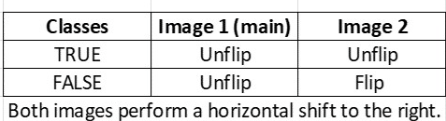

<Figure size 1200x1200 with 0 Axes>

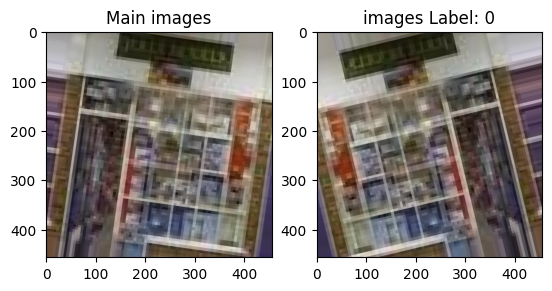

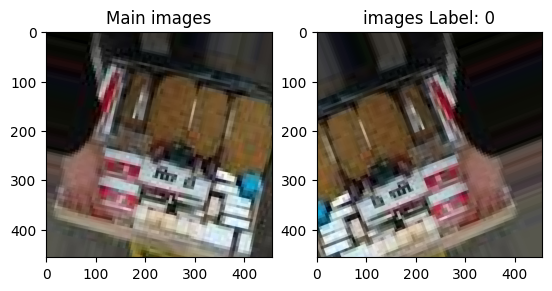

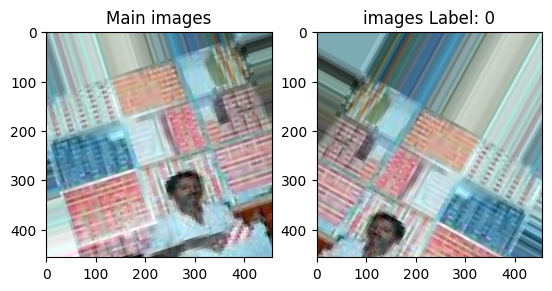

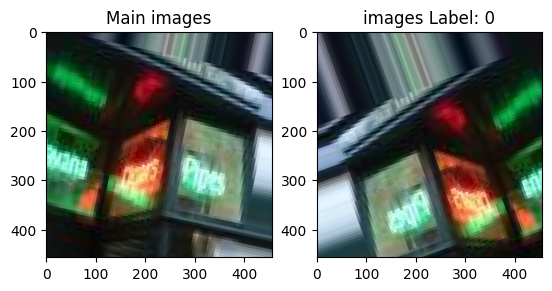

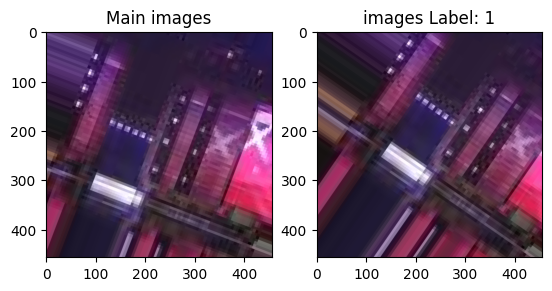

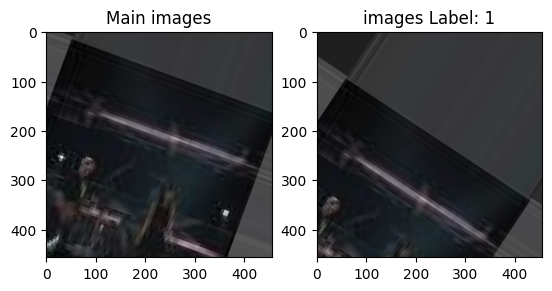

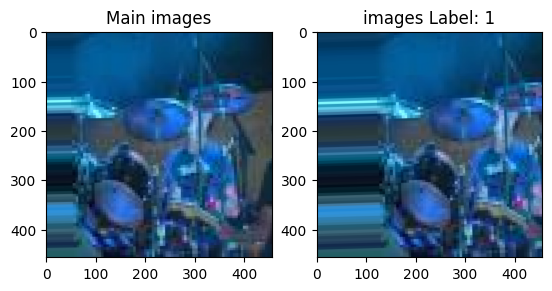

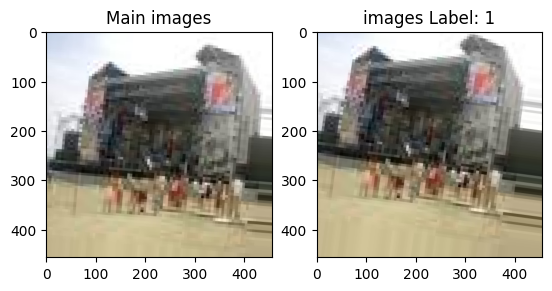

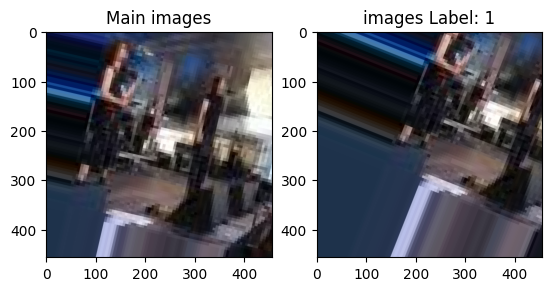

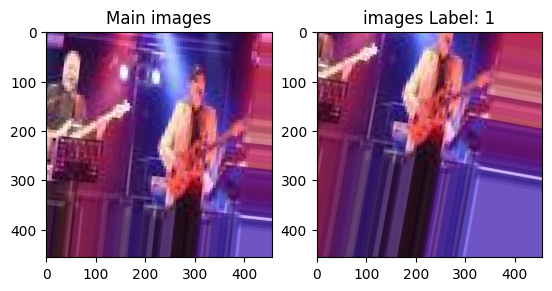

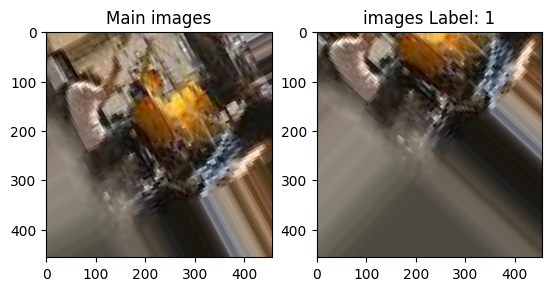

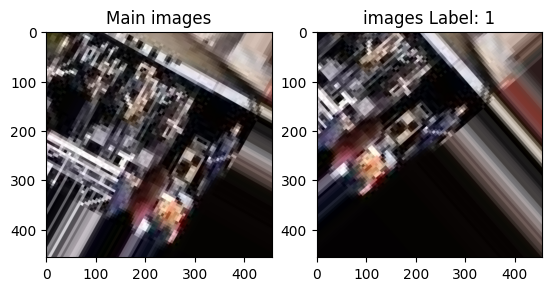

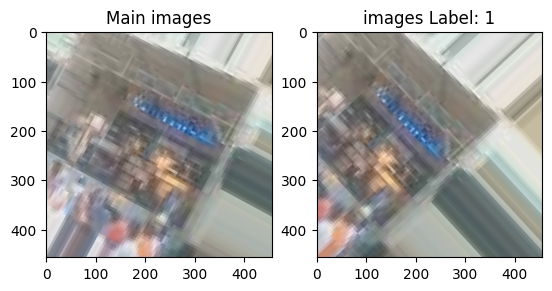

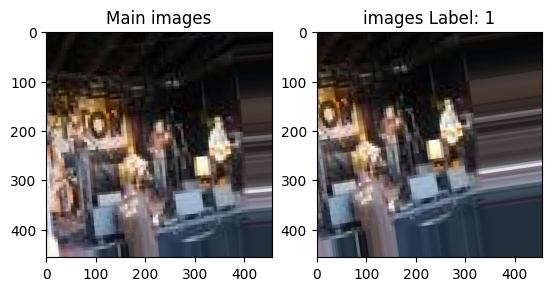

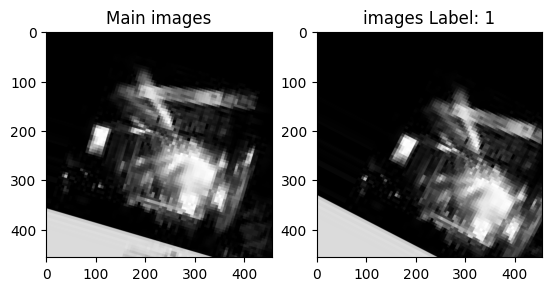

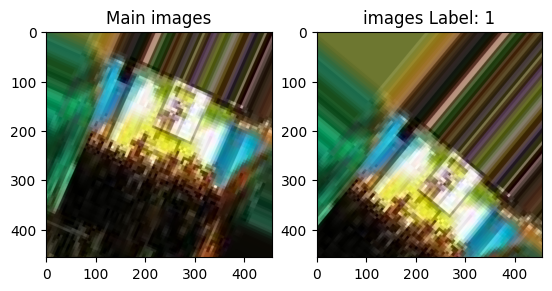

In [32]:
import cv2 
import PIL
from PIL import Image

%matplotlib inline
from matplotlib import pyplot as plt

batchXmain_train, batchX2_train = batchX_train[0], batchX_train[1]

fig = plt.figure(figsize=(12, 12))
for i in range(len(batchXmain_train)):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(batchXmain_train[i])
    ax1.set_title("Main images")
    ax2.imshow(batchX2_train[i])
    ax2.set_title(f"images Label: {int(batchY_train[i])}")
    plt.show()